<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
# <font color='blue'>Data Science Academy</font>
### <font color='blue'>Modelagem de Séries Temporais e Real-Time Analytics com Apache Spark e Databricks</font>
### <font color='blue'>Projeto 1 - Tarefa 3</font>
### <font color='blue'>Prevendo Usuários Ativos em Um Web Site</font>

Agora que você está familizarizado com o conceito de estacionariedade, podemos estudar como transformar nossa série em estacionária. Estudaremos esse tópico durante algumas aulas.

Lembre-se que para usar os modelos de previsão de séries temporais é necessário converter primeiro as séries não estacionárias em séries estacionárias.

## Instalando e Carregando os Pacotes

In [1]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
# !pip install -q -U watermark

In [2]:
# Imports para manipulação de dados
import numpy as np
import pandas as pd

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns

# Imports para análise de dados
import scipy
from scipy.stats import boxcox
import statsmodels
from statsmodels.tsa.stattools import adfuller

In [3]:
# Formatação para os gráficos e tabelas
plt.style.use('ggplot')
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# Formatando os labels dos gráficos
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'

In [5]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy"

Author: Data Science Academy



## Carregando o Conjunto de Dados

In [6]:
# Carrega os dados
# Observe que estamos carregando os dados e já definindo a data como índice com o parâmetro index_col = 0
dados = pd.read_csv('dataset.csv', 
                    header = None, 
                    index_col = 0,
                    names = ['usuarios_ativos'])

In [7]:
# Série
dados.head()

,usuarios_ativos
2013-01,110
2013-02,121
2013-03,135
2013-04,127
2013-05,128


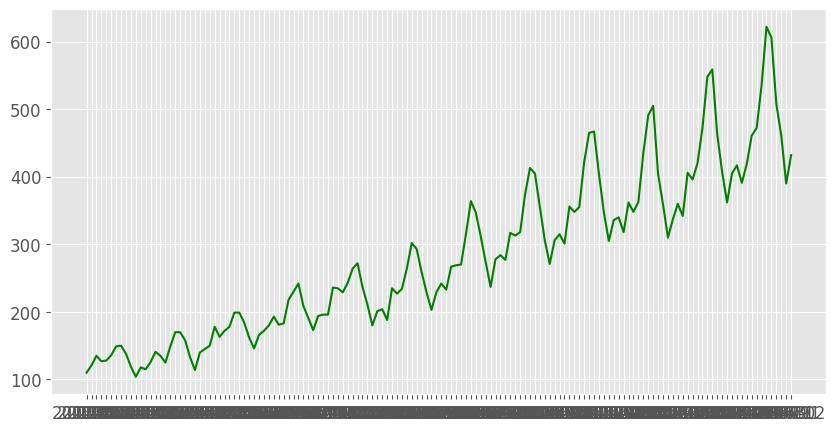

In [8]:
# Plot
plt.figure(figsize = (10, 5))
plt.plot(dados['usuarios_ativos'], color = "green")
plt.show()

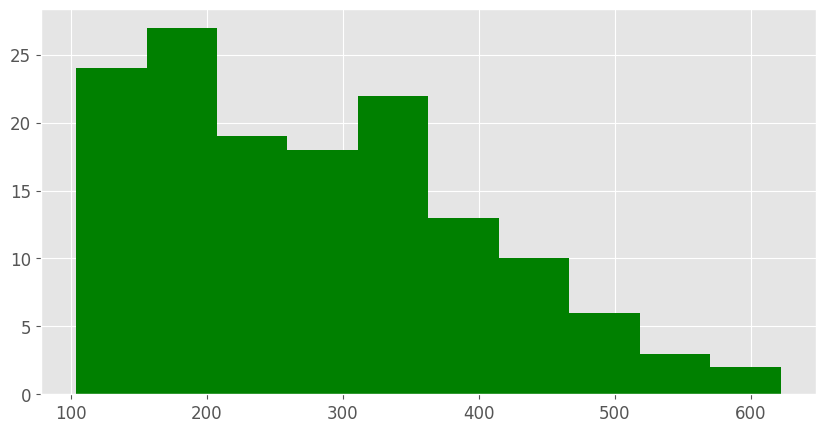

In [9]:
# Histograma
plt.figure(figsize = (10, 5))
plt.hist(dados['usuarios_ativos'], color = "green")
plt.show()

In [10]:
# Média da série
dados['usuarios_ativos'].mean()

np.float64(280.4166666666667)

In [11]:
# Desvio Padrão da série
dados['usuarios_ativos'].std()

np.float64(119.82554335015902)

O conjunto de dados é **não estacionário**, o que significa que a média e a variância das observações mudam ao longo do tempo. Isso dificulta a modelagem por métodos estatísticos clássicos, como ARIMA, e métodos mais sofisticados de aprendizado de máquina, como redes neurais.

A não estacionaridade é causada pelo que parece ser uma tendência crescente e um componente de sazonalidade.

Além disso, a quantidade de alteração ou a variância está aumentando com o tempo. Isso fica claro quando você olha para o tamanho do componente sazonal e percebe que a amplitude (de baixo para cima) está aumentando (vimos isso com o gráfico dos boxplots).

Vamos fazer ciência e experimentar diferentes técnicas de transformação a fim de converter a série em estacionária.

## Transformação de Log

Séries temporais podem ser linearizadas usando o logaritmo dos valores. Isso é chamado de transformação de log. Você com certeza lembra do que é logaritmo pois estudou isso no ensino fundamental. :-)

As transformações de log são populares em dados de séries temporais, pois são eficazes na remoção da variação exponencial.

É importante observar que esta operação assume que os valores são positivos e diferentes de zero. É comum transformar observações adicionando uma constante fixa para garantir que todos os valores de entrada atendam a esse requisito. Por exemplo: serie_transformada_y = log(constante + x)

In [12]:
# Vamos aplicar uma transformação de log usando np.log() e gravamos o resultado em uma nova coluna do nosso dataset
dados['usuarios_ativos_log'] = np.log(dados['usuarios_ativos'])
dados.head()

,usuarios_ativos,usuarios_ativos_log
2013-01,110,4.700480
2013-02,121,4.795791
2013-03,135,4.905275
2013-04,127,4.844187
2013-05,128,4.852030


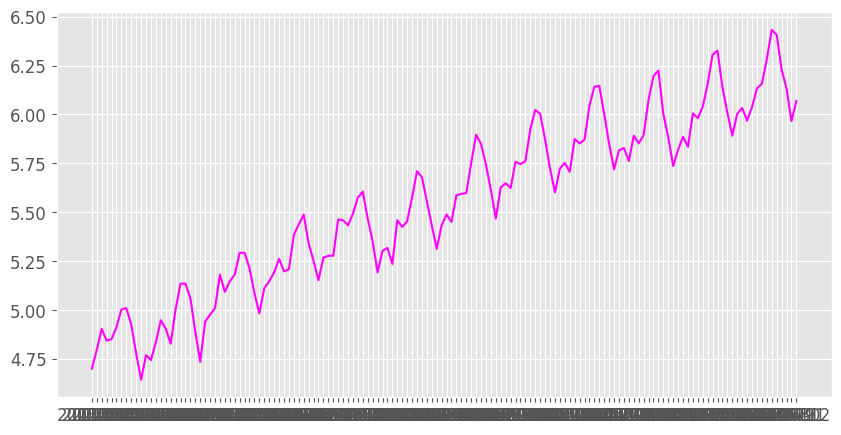

In [13]:
# Plot da série transformada
plt.figure(figsize = (10, 5))
plt.plot(dados['usuarios_ativos_log'], color = "magenta")
plt.show()

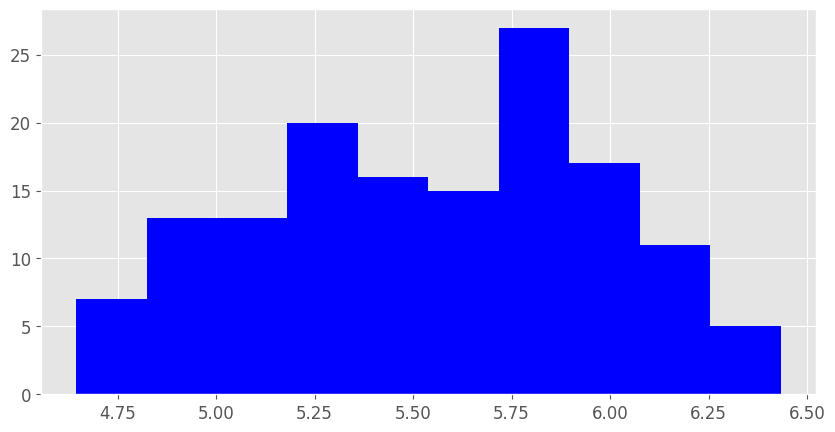

In [14]:
# Histograma da série transformada
plt.figure(figsize = (10, 5))
plt.hist(dados['usuarios_ativos_log'], color = "blue")
plt.show()

Análise:

-  A execução do exemplo resulta em uma tendência que parece mais linear. O gráfico de linha mostra um crescimento e variação aparentemente lineares.

- O histograma também mostra uma distribuição de observações do tipo gaussiana mais uniforme.

Vamos testar a estacionaridade.

In [15]:
# Função para testar a estacionaridade
def dsa_testa_estacionaridade(serie, window = 12, title='Estatísticas Móveis e Teste Dickey-Fuller'):
    """
    Função para testar a estacionaridade de uma série temporal.
    
    Parâmetros:
    - serie: pandas.Series. Série temporal a ser testada.
    - window: int. Janela para cálculo das estatísticas móveis.
    - title: str. Título para os gráficos.
    """
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = window).mean()
    rolstd = serie.rolling(window = window).std()

    # Plot das estatísticas móveis
    plt.figure(figsize = (14, 6))
    plt.plot(serie, color = 'blue', label = 'Original')
    plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    plt.plot(rolstd, color = 'black', label = 'Desvio Padrão Móvel')
    plt.legend(loc='best')
    plt.title(title)
    plt.show(block=False)
    
    # Teste Dickey-Fuller
    print('\nResultado do Teste Dickey-Fuller:')
    dfteste = adfuller(serie, autolag='AIC')
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste', 
                                               'Valor-p', 
                                               'Número de Lags Consideradas', 
                                               'Número de Observações Usadas'])
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)' % key] = value
        
    print(dfsaida)
    
    # Conclusão baseada no valor-p
    if dfsaida['Valor-p'] > 0.05:
        print('\nConclusão:\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.\nEssa série provavelmente não é estacionária.')
    else:
        print('\nConclusão:\nO valor-p é menor que 0.05 e, portanto,temos evidências para rejeitar a hipótese nula.\nEssa série provavelmente é estacionária.')

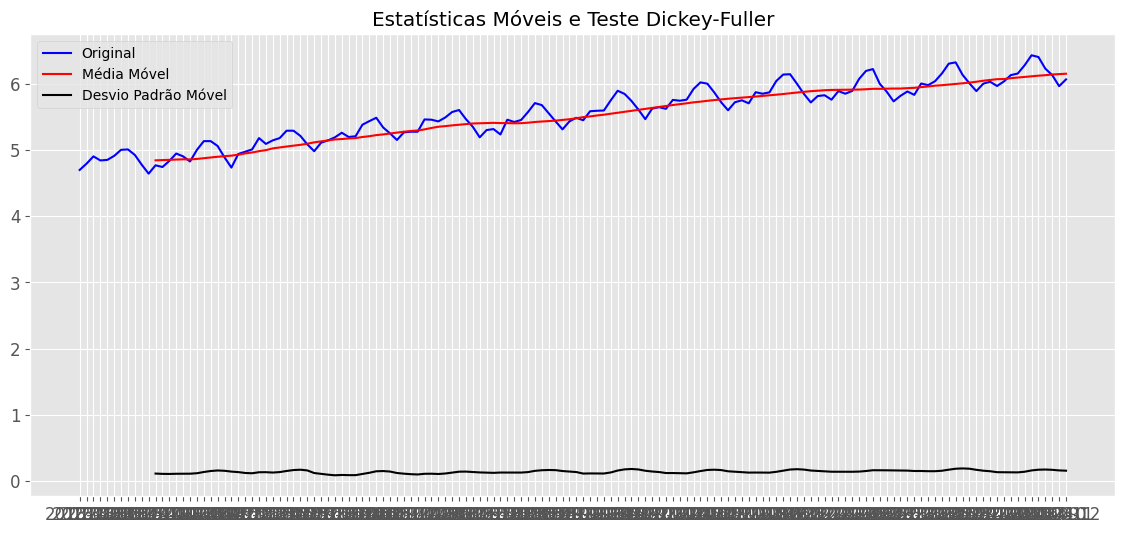


Resultado do Teste Dickey-Fuller:
Estatística do Teste             -1.682091
Valor-p                           0.440363
Número de Lags Consideradas      13.000000
Número de Observações Usadas    130.000000
Valor Crítico (1%)               -3.481682
Valor Crítico (5%)               -2.884042
Valor Crítico (10%)              -2.578770
dtype: float64

Conclusão:
O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [16]:
dsa_testa_estacionaridade(dados['usuarios_ativos_log'])

Análise:

- A Transformação de Log não converteu a série em estacionária. Não há como saber previamente se a técnica funciona ou não e por isso precisamos experimemtar. Por isso chamamos de Ciência de Dados.

## Transformação de Raiz Quadrada

Uma série temporal que tem uma tendência quadrática de crescimento pode ser linearizada calculando sua raiz quadrada.

É possível que nosso conjunto de dados mostre um crescimento quadrático. Se esse for o caso, poderíamos esperar que uma transformação de raiz quadrada, para reduzir a tendência de crescimento, seja linear e alterar a distribuição de observações para talvez ser quase gaussiana.

O exemplo abaixo executa uma raiz quadrada do conjunto de dados e plota os resultados.

In [17]:
# Transformação de Raiz Quadrada com np.sqrt()
dados_sqrt = np.sqrt(dados['usuarios_ativos'])

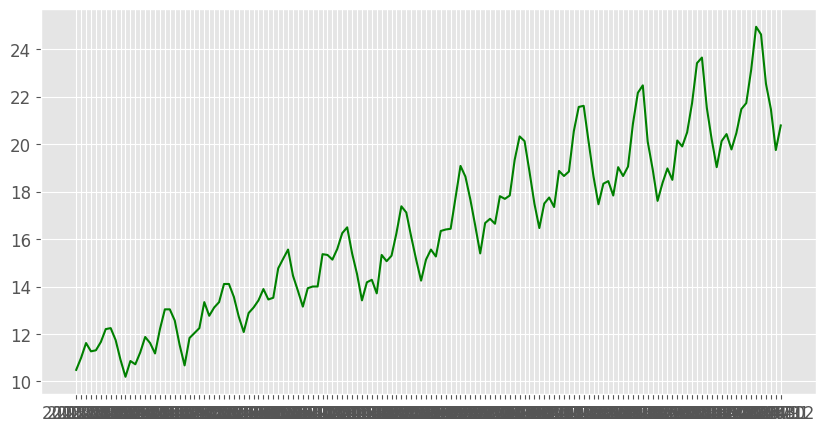

In [18]:
# Gráfico de Linha
plt.figure(figsize = (10, 5))
plt.plot(dados_sqrt, color = "green")
plt.show()

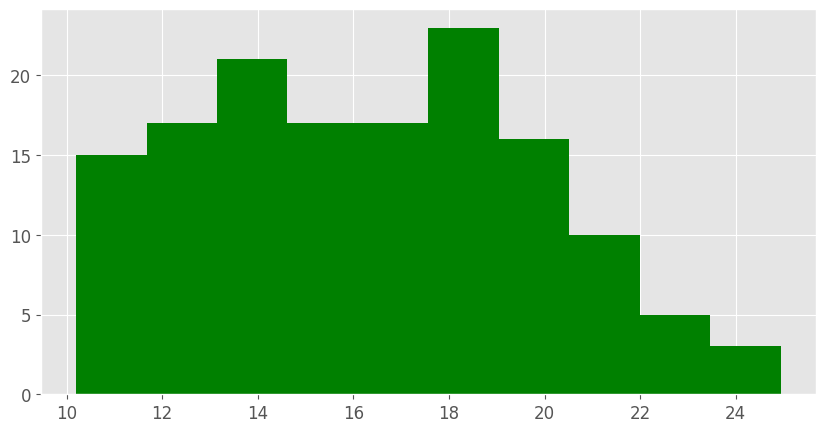

In [19]:
# Histograma
plt.figure(figsize = (10, 5))
plt.hist(dados_sqrt, color = "green")
plt.show()

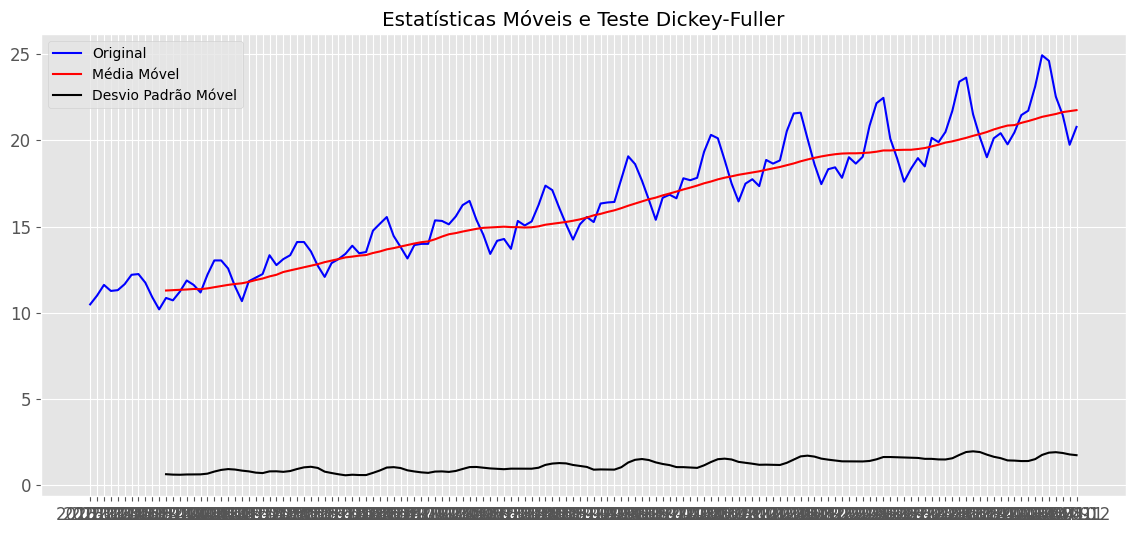


Resultado do Teste Dickey-Fuller:
Estatística do Teste             -0.335165
Valor-p                           0.920374
Número de Lags Consideradas      13.000000
Número de Observações Usadas    130.000000
Valor Crítico (1%)               -3.481682
Valor Crítico (5%)               -2.884042
Valor Crítico (10%)              -2.578770
dtype: float64

Conclusão:
O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [20]:
dsa_testa_estacionaridade(dados_sqrt)

Análise:

- Podemos ver que a tendência foi reduzida, mas não foi removida.

- O gráfico de linha ainda mostra uma variação crescente de ciclo para ciclo. E o histograma ainda mostra uma cauda longa à direita da distribuição, sugerindo uma distribuição exponencial ou de cauda longa.

## Transformação Box-Cox

A transformação de raiz quadrada e a transformação de log pertencem a uma classe de transformações denominadas transformações de potência.

A transformação Box-Cox é um método de transformação de dados configurável que suporta a raiz quadrada e a transformação de log, bem como um conjunto de transformações relacionadas.

Mais do que isso, pode ser configurado para avaliar um conjunto de transformações automaticamente e selecionar o melhor ajuste. A série resultante pode ser mais linear e a distribuição resultante mais gaussiana ou uniforme, dependendo do processo que a gerou.

A biblioteca scipy.stats fornece uma implementação da transformação Box-Cox. A função boxcox() usa um argumento, chamado lambda, que controla o tipo de transformação a ser executada.

Abaixo estão alguns valores comuns para lambda

- lambda = -1. é uma transformação recíproca.
- lambda = -0,5 é uma transformação de raiz quadrada recíproca.
- lambda = 0,0 é uma transformação de log.
- lambda = 0,5 é uma transformação de raiz quadrada.
- lambda = 1.0 não é transformação.

Vamos ao exemplo:

In [21]:
# Aplicando Transformação Box-Cox
dados['usuarios_ativos_box'] = boxcox(dados['usuarios_ativos'], lmbda = 0.0)

In [22]:
dados.head()

,usuarios_ativos,usuarios_ativos_log,usuarios_ativos_box
2013-01,110,4.700480,4.700480
2013-02,121,4.795791,4.795791
2013-03,135,4.905275,4.905275
2013-04,127,4.844187,4.844187
2013-05,128,4.852030,4.852030


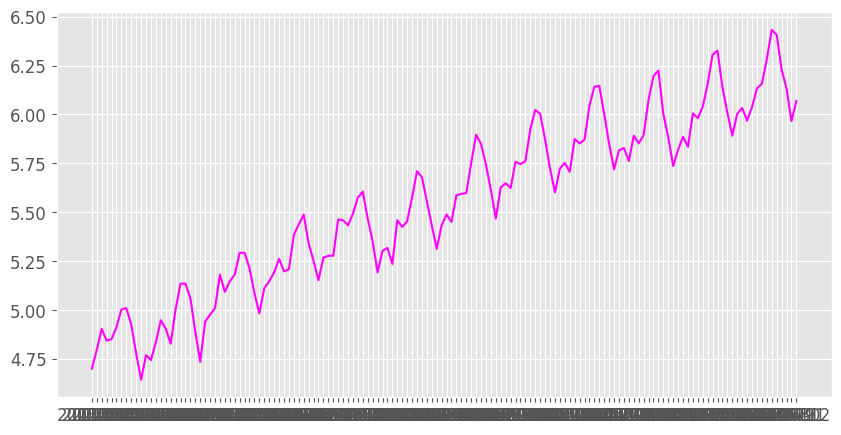

In [23]:
# Plot da série transformada
plt.figure(figsize = (10, 5))
plt.plot(dados['usuarios_ativos_box'], color = "magenta")
plt.show()

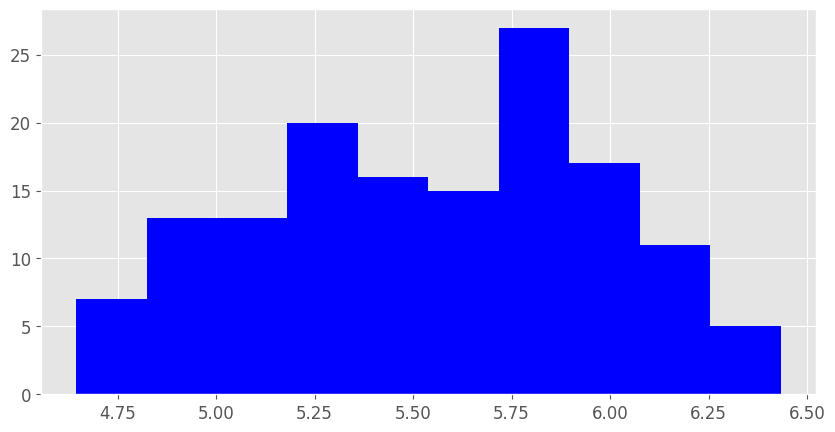

In [24]:
# Histograma
plt.figure(figsize = (10, 5))
plt.hist(dados['usuarios_ativos_box'], color = "blue")
plt.show()

Podemos definir o parâmetro lambda como None (o padrão) e deixar a função encontrar um valor ajustado estatisticamente.

O exemplo a seguir demonstra esse uso, retornando o conjunto de dados transformado e o valor lambda escolhido.

In [25]:
# Aplicando Transformação Box-Cox
dados['usuarios_ativos_box_2'], lam_value = boxcox(dados['usuarios_ativos'])
print('Valor Ideal de Lambda: %f' % lam_value)
dados.head()

Valor Ideal de Lambda: 0.141909


,usuarios_ativos,usuarios_ativos_log,usuarios_ativos_box,usuarios_ativos_box_2
2013-01,110,4.700480,4.700480,6.683589
2013-02,121,4.795791,4.795791,6.870559
2013-03,135,4.905275,4.905275,7.088477
2013-04,127,4.844187,4.844187,6.966470
2013-05,128,4.852030,4.852030,6.982076


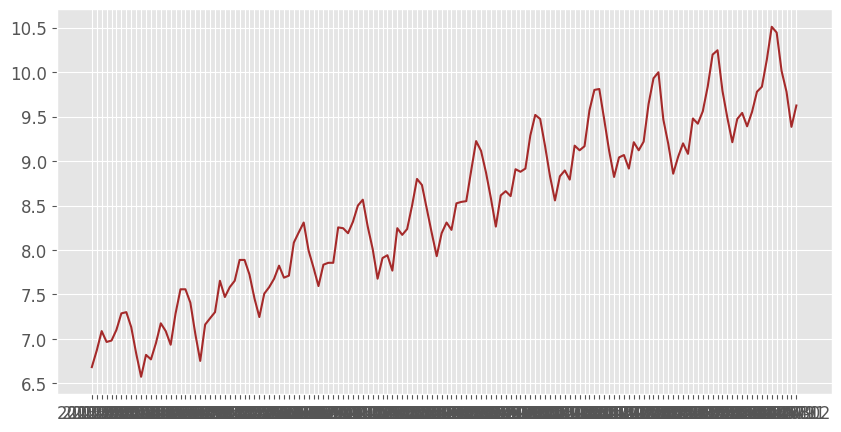

In [26]:
# Plot da série transformada
plt.figure(figsize = (10, 5))
plt.plot(dados['usuarios_ativos_box_2'], color = "brown")
plt.show()

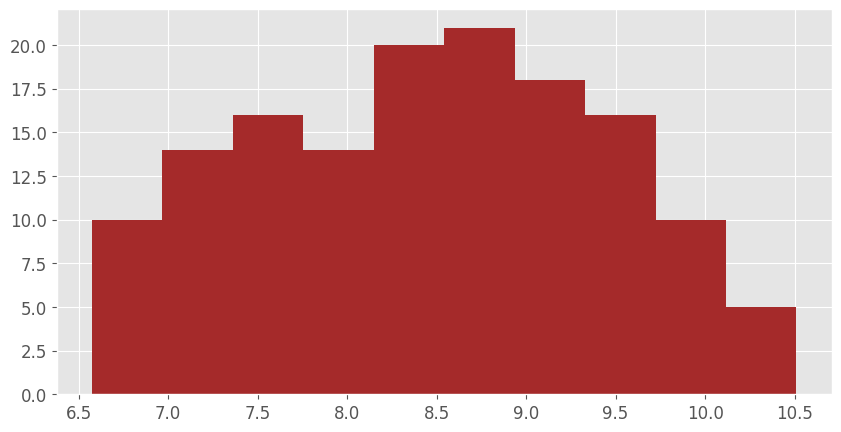

In [27]:
# Histograma
plt.figure(figsize = (10, 5))
plt.hist(dados['usuarios_ativos_box_2'], color = "brown")
plt.show()

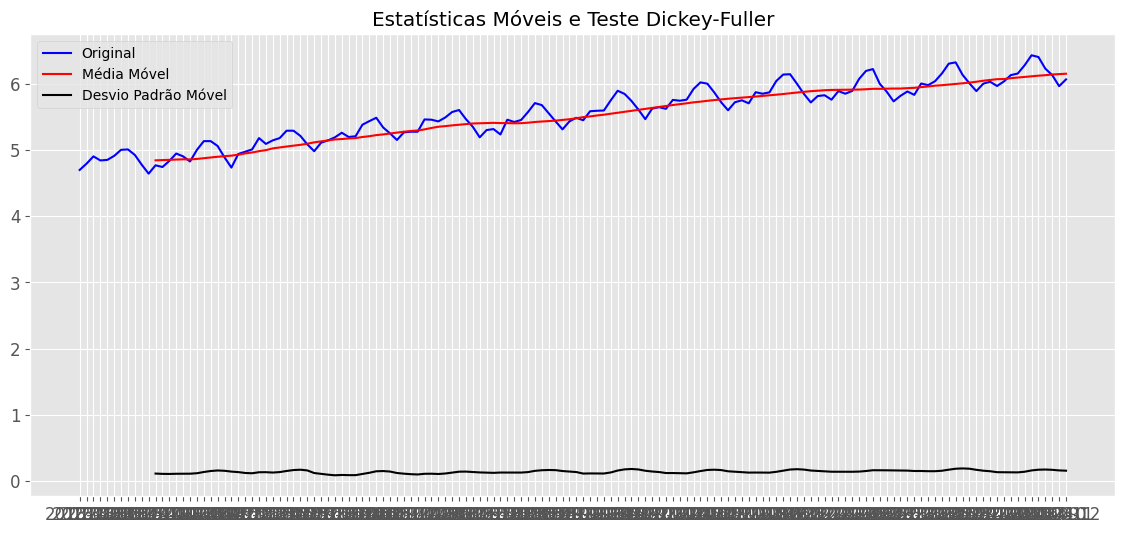


Resultado do Teste Dickey-Fuller:
Estatística do Teste             -1.682091
Valor-p                           0.440363
Número de Lags Consideradas      13.000000
Número de Observações Usadas    130.000000
Valor Crítico (1%)               -3.481682
Valor Crítico (5%)               -2.884042
Valor Crítico (10%)              -2.578770
dtype: float64

Conclusão:
O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [28]:
dsa_testa_estacionaridade(dados['usuarios_ativos_box'])

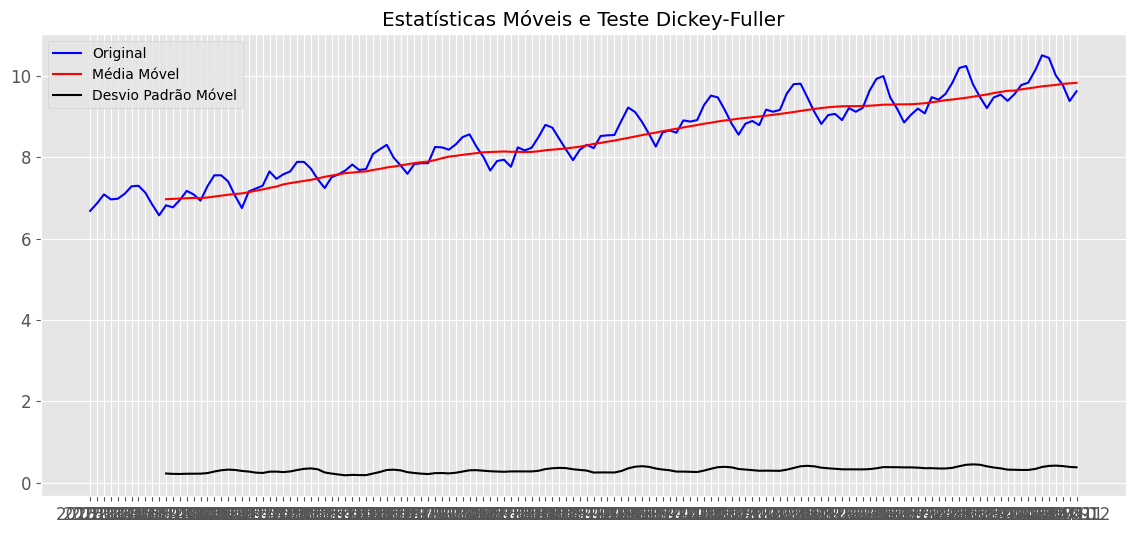


Resultado do Teste Dickey-Fuller:
Estatística do Teste             -1.313294
Valor-p                           0.623069
Número de Lags Consideradas      13.000000
Número de Observações Usadas    130.000000
Valor Crítico (1%)               -3.481682
Valor Crítico (5%)               -2.884042
Valor Crítico (10%)              -2.578770
dtype: float64

Conclusão:
O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [29]:
dsa_testa_estacionaridade(dados['usuarios_ativos_box_2'])

Análise:

- A execução do exemplo gerou o valor lambda de 0.141909.

- Podemos ver que isso está muito próximo de um valor lambda de 0,0, resultando em uma transformação de log mais forte (e menor) que 0.5 para a transformação de raiz quadrada.

Aparentemente nenhuma das técnicas anteriores apresentou resultado para tornar nossa série estacionária. Então, teremos que subir o nível a aplicar técnicas mais avançadas. 

É o que faremos no próximo capítulo.

In [30]:
%reload_ext watermark
%watermark -a "Data Science Academy"

Author: Data Science Academy



In [31]:
#%watermark -v -m

In [32]:
#%watermark --iversions

# Fim da Tarefa 3